## 이탈 요인 분석

### 데이터셋 준비

In [ ]:
import datetime

v_acc_atd['attendance_date'] = pd.to_datetime(v_acc_atd['attendance_date'])

# 6월 12일 기준
target_date = datetime.date(2023, 6, 12)

atd_before_612 = v_acc_atd[v_acc_atd['attendance_date'] <= '2023-06-12']

atd_user_ids = set(atd_before_612['user_id'].unique())

vote_before_612 = v_acc_uqrec[v_acc_uqrec['created_at'] <= '2023-06-12']

vote_user_ids = set(vote_before_612['user_id'].unique())

user_df = pd.DataFrame({'user_id': list(atd_user_ids)})
user_df = user_df.sort_values('user_id').reset_index(drop=True)

vote_count = vote_before_612['user_id'].value_counts().sort_index().reset_index()
vote_count.columns = ['user_id', 'vote_count']

elected_count = vote_before_612['chosen_user_id'].value_counts().sort_index().reset_index()
elected_count.columns = ['user_id', 'elected_count']

user_df = user_df.merge(vote_count, on='user_id', how='left').fillna(0)
user_df = user_df.merge(elected_count, on='user_id', how='left').fillna(0)

atd_after_612 = v_acc_atd[v_acc_atd['attendance_date'] > '2023-06-12']

v_acc_user['friend_count'] = v_acc_user['friend_id_list'].apply(lambda x: len(x.strip('[]').split(',')) if pd.notna(x) and x != '[]' else 0)

user_df_userid = set(user_df['user_id'].unique())

v_acc_userdf = v_acc_user[v_acc_user['id'].isin(user_df_userid)]

v_acc_userdf = v_acc_userdf[['id', 'gender', 'point', 'friend_count']]

v_acc_userdf.rename(columns={'id': 'user_id'}, inplace=True)

user_df = user_df.merge(v_acc_userdf, on='user_id', how='left')

user_df['gender'].value_counts(dropna=False)

v_acc_pay['created_at'] = pd.to_datetime(v_acc_pay['created_at'])

pay_before_612 = v_acc_pay[v_acc_pay['created_at'] <= '2023-06-12']

pay_before_612 = pay_before_612[pay_before_612['user_id'].isin(user_df_userid)]

pay_before_612.rename(columns={'productId': 'price'}, inplace=True)

rename_dict = {'heart.777':777,
               'heart.200':200,
               'heart.1000':1000,
               'heart.4000':4000}

pay_before_612['price'] = pay_before_612['price'].map(rename_dict)

pay_count = pay_before_612['user_id'].value_counts().sort_index().reset_index()
pay_count.columns = ['user_id', 'pay_count']

pay_total = pay_before_612.groupby('user_id')['price'].sum().sort_index().reset_index()
pay_total.columns = ['user_id', 'pay_total']

pay_df = pay_count.merge(pay_total, on='user_id', how='left')

user_df = user_df.merge(pay_df, on='user_id', how='left').fillna(0)

user_attendance = atd_before_612.sort_values(['user_id', 'attendance_date'])

# 각 사용자별로 이전 출석일과의 차이 계산
user_attendance['days_between'] = user_attendance.groupby('user_id')['attendance_date'].diff().dt.days

# 사용자별 평균 접속 간격 계산
user_intervals = user_attendance.groupby('user_id').agg({
    'days_between': 'mean',  # 평균 접속 간격
    'attendance_date': ['count', 'min', 'max']  # 출석 횟수, 첫 출석일, 마지막 출석일
}).reset_index()

user_intervals.columns = ['user_id', 'avg_interval', 'attendance_count', 'first_attendance', 'last_attendance']
user_intervals.drop(columns=['attendance_count', 'first_attendance', 'last_attendance'], inplace=True)
user_df = user_df.merge(user_intervals, on='user_id', how='left')

user_df['avg_interval'] = user_df['avg_interval'].fillna(0)

# 사용자별 최대 접속 간격 계산
user_intervals = user_attendance.groupby('user_id').agg({
    'days_between': 'max',  # 최대 접속 간격
    'attendance_date': ['count', 'min', 'max']  # 출석 횟수, 첫 출석일, 마지막 출석일
}).reset_index()

user_intervals.columns = ['user_id', 'max_interval', 'attendance_count', 'first_attendance', 'last_attendance']
user_intervals.drop(columns=['first_attendance', 'last_attendance'], inplace=True)
user_df = user_df.merge(user_intervals, on='user_id', how='left')

# NaN 값 처리
user_df['max_interval'] = user_df['max_interval'].fillna(0)
user_df['attendance_count'] = user_df['attendance_count'].fillna(0)


base_date = pd.to_datetime('2023-06-13')

# avg_interval 이내에 출석한 경우
# 6월 12일 이후 각 사용자의 첫 출석일 확인
after_612_first_attendance = atd_after_612.groupby('user_id')['attendance_date'].min().reset_index()
after_612_first_attendance['attendance_date'] = pd.to_datetime(after_612_first_attendance['attendance_date'])

# 6월 12일부터 첫 출석까지의 간격 계산
after_612_first_attendance['days_until_first_attendance'] = (after_612_first_attendance['attendance_date'] - base_date).dt.days

user_df = user_df.merge(after_612_first_attendance[['user_id', 'days_until_first_attendance']],
                       on='user_id',
                       how='left')

# max_interval 이내에 출석한 경우
# 이탈 여부 판단
user_df['is_breakaway'] = ~(
    (user_df['days_until_first_attendance'] >= 0) &  # 6월 12일 이후 첫 출석일이 존재하고
    (user_df['days_until_first_attendance'] <= user_df['avg_interval'])  # avg_interval 이내에 출석한 경우
)

user_df = user_df.drop('days_until_first_attendance', axis=1)

user_df = user_df.merge(after_612_first_attendance[['user_id', 'days_until_first_attendance']],
                       on='user_id',
                       how='left')

# 이탈 여부 판단
user_df['is_breakaway_plenty'] = ~(
    (user_df['days_until_first_attendance'] >= 0) &  # 6월 12일 이후 첫 출석일이 존재하고
    (user_df['days_until_first_attendance'] <= user_df['max_interval'])  # max_interval 이내에 출석한 경우
)

user_df = user_df.drop('days_until_first_attendance', axis=1)

# 이탈 유저의 평균 출석 간격을 365일로 설정
user_df.loc[(user_df['avg_interval'] == 0) & (user_df['is_breakaway'] == True), 'avg_interval'] = 365
user_df.loc[(user_df['max_interval'] == 0) & (user_df['is_breakaway_plenty'] == True), 'max_interval'] = 365

gender_int = {'M': 0, 'F': 1}
user_df['gender'] = user_df['gender'].map(gender_int)

delta_point_df = v_acc_point.groupby('user_id')['delta_point'].sum().sort_values(ascending=False).reset_index()

user_df = user_df.merge(delta_point_df, on='user_id', how='left').fillna(0)

df1 = v_acc_uqrec.groupby('user_id')['status'].value_counts().sort_index().reset_index()

df1 = df1[df1['status'] == 'I']

df1.rename(columns={'count': 'hint_count'}, inplace=True)
df1.drop(columns=['status'], inplace=True)
user_df = user_df.merge(df1, on='user_id', how='left').fillna(0)

use_point = v_acc_point[v_acc_point['delta_point'] < 0]
user_use_point = use_point.groupby('user_id')['delta_point'].sum().sort_values(ascending=False).reset_index()
user_use_point.rename(columns={'delta_point': 'use_point'}, inplace=True)
user_df = user_df.merge(user_use_point, on='user_id', how='left').fillna(0)

user_df['hint_open_ratio'] = np.where(user_df['elected_count'] == 0, 0, user_df['hint_count'] / user_df['elected_count'])
user_df['vote_survice_use_score'] = user_df['vote_count'] * 2 + user_df['elected_count']

# 투표를 이성에게 받았는지 동성에게 받았는지 확인
chosen_df = v_acc_uqrec[['chosen_user_id', 'user_id', 'question_id']]
chosen_df.rename(columns={'user_id': 'pick_user_id'}, inplace=True)

gender_df = v_acc_user[['id', 'gender']]


chosen_df = chosen_df.merge(gender_df, left_on='chosen_user_id', right_on='id', how='left')
chosen_df.rename(columns={'gender': 'chosen_gender'}, inplace=True)

chosen_df = chosen_df.merge(gender_df, left_on='pick_user_id', right_on='id', how='left')
chosen_df.rename(columns={'gender': 'pick_gender'}, inplace=True)
chosen_df.head()

chosen_df.drop(columns=['id_x', 'id_y'], inplace=True)

chosen_df['is_same_gender'] = chosen_df['chosen_gender'] == chosen_df['pick_gender']

동성_선택 = chosen_df.groupby('chosen_user_id')['is_same_gender'].apply(lambda x: sum(x))
이성_선택 = chosen_df.groupby('chosen_user_id')['is_same_gender'].apply(lambda x: sum(~x))

gender_counts = pd.DataFrame({
    'same_gender': 동성_선택,
    'diff_gender': 이성_선택
})

chosen_df = chosen_df.merge(
    gender_counts,
    left_on='chosen_user_id',
    right_index=True,
    how='left'
)

chosen_df['total_selected'] = chosen_df['same_gender'] + chosen_df['diff_gender']
chosen_df['same_gender_ratio'] = (chosen_df['same_gender'] / chosen_df['total_selected']).round(3)
chosen_df['diff_gender_ratio'] = (chosen_df['diff_gender'] / chosen_df['total_selected']).round(3)

chosen_df_merge = chosen_df[['chosen_user_id', 'same_gender', 'diff_gender', 'same_gender_ratio', 'diff_gender_ratio']]

chosen_df_merge.rename(columns={'chosen_user_id': 'user_id'}, inplace=True)

user_df = user_df.merge(chosen_df_merge, on='user_id', how='left').fillna(0)

user_df = user_df[['user_id', 'vote_count', 'elected_count', 'same_gender', 'diff_gender', 'same_gender_ratio', 'diff_gender_ratio',
         'gender', 'friend_count', 'pay_count', 'avg_interval', 'attendance_count', 'hint_count', 'use_point',
         'hint_open_ratio','is_breakaway_plenty']]
user_df.drop_duplicates(inplace=True)
user_df.head(3)

C:\Users\rkdal\AppData\Local\Temp\ipykernel_28368\2699142002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_acc_user['friend_count'] = v_acc_user['friend_id_list'].apply(lambda x: len(x.strip('[]').split(',')) if pd.notna(x) and x != '[]' else 0)
C:\Users\rkdal\AppData\Local\Temp\ipykernel_28368\2699142002.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_df.rename(columns={'user_id': 'pick_user_id'}, inplace=True)
C:\Users\rkdal\AppData\Local\Temp\ipykernel_28368\2699142002.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy

,user_id,vote_count,elected_count,same_gender,diff_gender,same_gender_ratio,diff_gender_ratio,gender,friend_count,pay_count,avg_interval,attendance_count,hint_count,use_point,hint_open_ratio,is_breakaway_plenty
0,832151,0.0,0.0,0.0,0.0,0.0,0.0,0,51,0.0,365.0,1,0.0,0.0,0.0,True
1,832340,0.0,0.0,0.0,0.0,0.0,0.0,1,57,0.0,1.0,2,0.0,0.0,0.0,True
2,832986,0.0,0.0,0.0,0.0,0.0,0.0,0,18,0.0,365.0,1,0.0,0.0,0.0,True


### 이탈 요인 분석(XGBoost)

클래스 분포:
is_breakaway_plenty
True     0.836802
False    0.163198
Name: proportion, dtype: float64


[I 2025-01-13 02:12:17,065] A new study created in memory with name: no-name-dfd6cd41-eb05-44b8-a5f3-b05d105bd53c



SMOTE 적용 후 클래스 분포:
is_breakaway_plenty
True     0.5
False    0.5
Name: proportion, dtype: float64


[I 2025-01-13 02:12:40,152] Trial 0 finished with value: 0.9893842356445411 and parameters: {'learning_rate': 0.022446956015044636, 'n_estimators': 808, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.6065296258106467, 'colsample_bytree': 0.6944231570945523, 'gamma': 4.269586132085918, 'reg_alpha': 7.586450837147328e-06, 'reg_lambda': 5.7261620610141104e-05}. Best is trial 0 with value: 0.9893842356445411.
[I 2025-01-13 02:12:52,492] Trial 1 finished with value: 0.9869442471982289 and parameters: {'learning_rate': 0.23038030766098713, 'n_estimators': 904, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6228860076011007, 'colsample_bytree': 0.5372353183106423, 'gamma': 2.7622024630369975, 'reg_alpha': 1.3540345291734246e-08, 'reg_lambda': 0.0077213732493527}. Best is trial 0 with value: 0.9893842356445411.
[I 2025-01-13 02:12:57,716] Trial 2 finished with value: 0.9503171658840938 and parameters: {'learning_rate': 0.02882382046120371, 'n_estimators': 207, 'max_depth': 4, 'm

Best trial:
  AUC: 0.9922
  Best hyperparameters: 
    learning_rate: 0.1439493694804499
    n_estimators: 793
    max_depth: 10
    min_child_weight: 1
    subsample: 0.6007563517093372
    colsample_bytree: 0.7552973062478188
    gamma: 0.7385211567253511
    reg_alpha: 0.044477283894106795
    reg_lambda: 4.603089407617221e-05

Optuna 최적화 모델 성능 평가:
Accuracy: 0.9368
Precision: 0.9756
Recall: 0.9482
F1 Score: 0.9617
ROC AUC: 0.9812


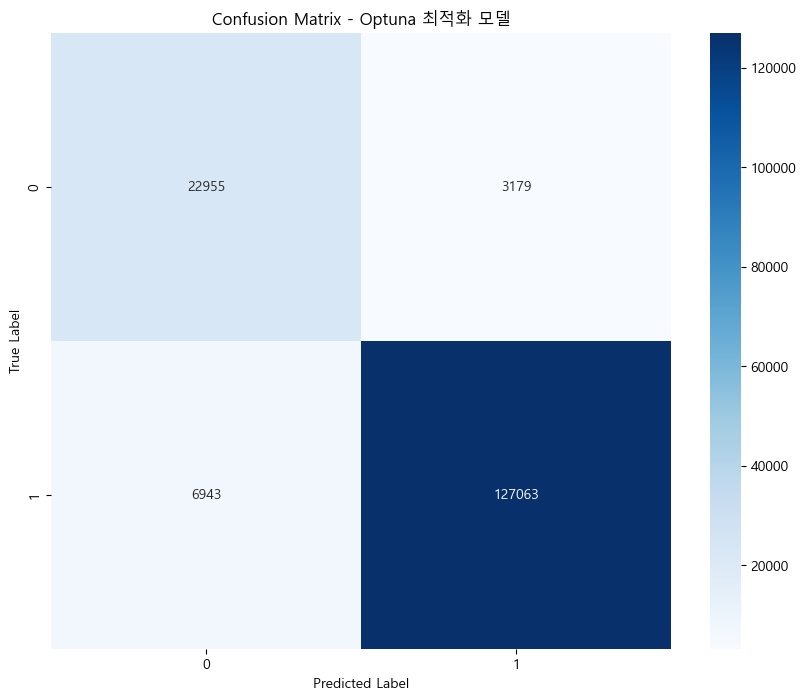

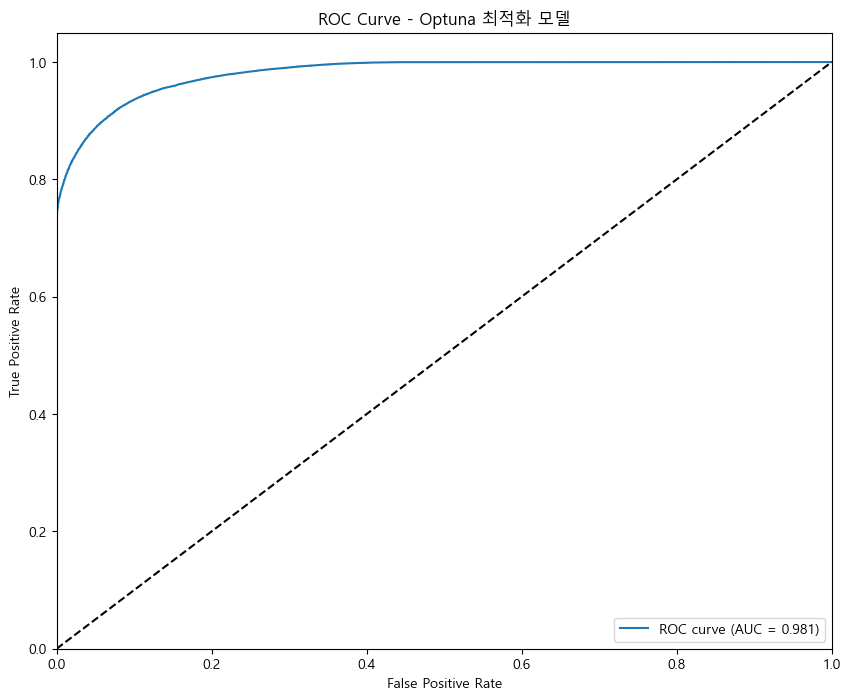

<Figure size 1000x600 with 0 Axes>

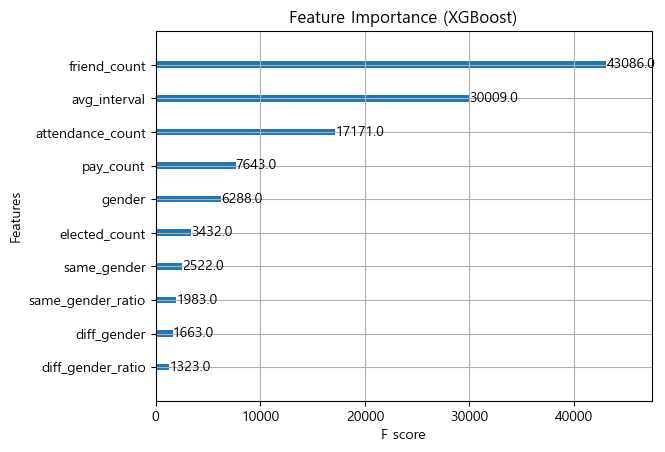

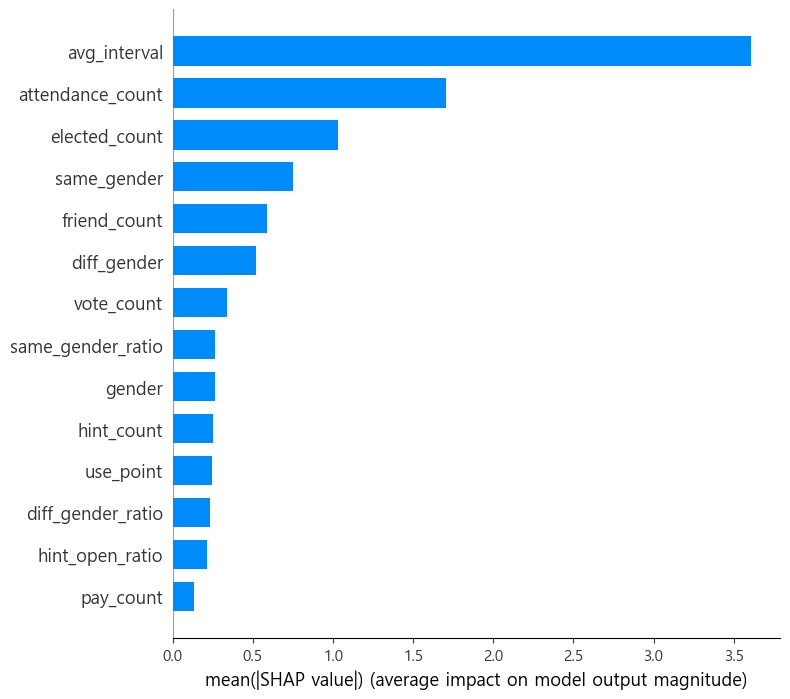

<Figure size 1000x600 with 0 Axes>

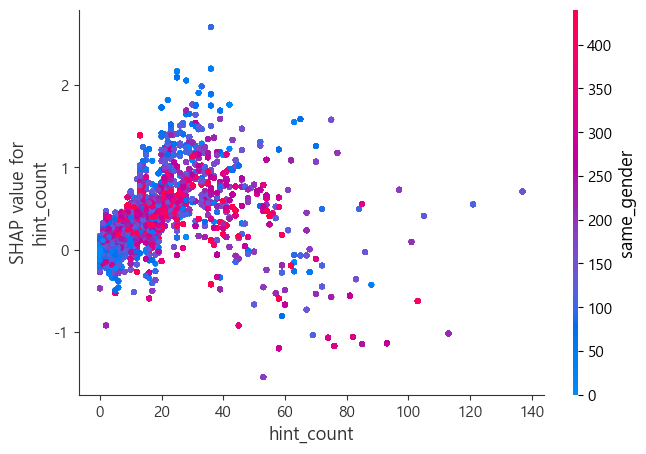

<Figure size 1000x600 with 0 Axes>

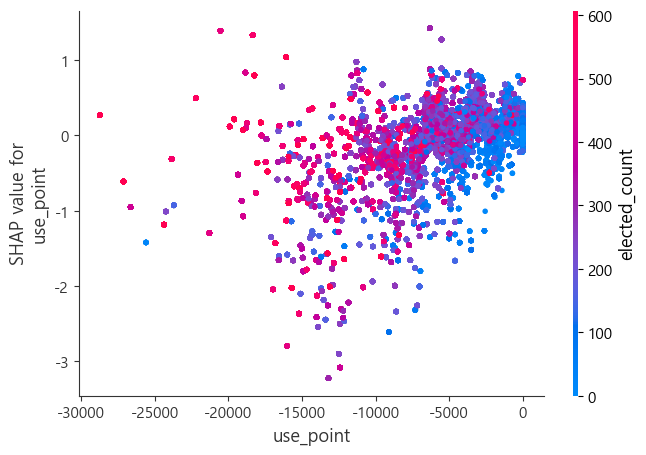

<Figure size 1000x600 with 0 Axes>

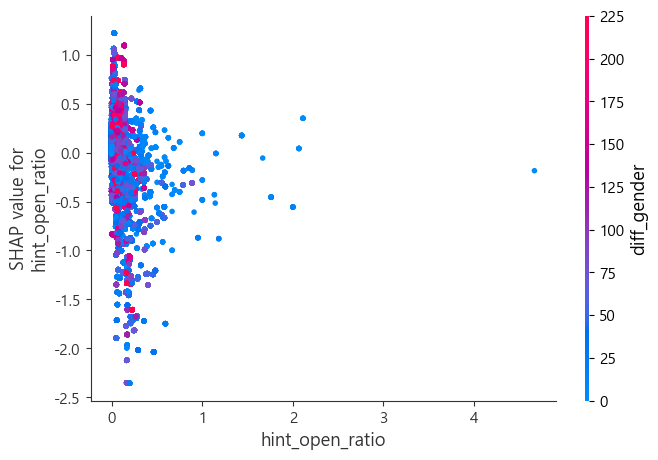

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve
import shap
from imblearn.over_sampling import SMOTE
import optuna
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import StratifiedKFold

drop_columns = ['user_id']
X = user_df.drop(drop_columns + ['is_breakaway_plenty'], axis=1)
y = user_df['is_breakaway_plenty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("클래스 분포:")
print(y_train.value_counts(normalize=True))

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nSMOTE 적용 후 클래스 분포:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

# Optuna를 사용한 하이퍼파라미터 튜닝
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'tree_method': 'gpu_hist',  # GPU 사용
        'gpu_id': 0,  # GPU 장치 번호

        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': len(y_train_resampled[y_train_resampled==0]) / len(y_train_resampled[y_train_resampled==1]),
        'random_state': 42
    }

    model = xgb.XGBClassifier(**param)

    # 5-Fold 교차 검증
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='roc_auc', n_jobs=-1)

    return auc_scores.mean()

# Optuna 스터디 생성 시 더 많은 trials 설정
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=1200)

print("Best trial:")
trial = study.best_trial

print(f"  AUC: {trial.value:.4f}")
print("  Best hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# 최적 하이퍼파라미터로 모델 학습
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'auc'
best_params['use_label_encoder'] = False
best_params['scale_pos_weight'] = len(y_train_resampled[y_train_resampled==0]) / len(y_train_resampled[y_train_resampled==1])
best_params['random_state'] = 42

best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train_resampled, y_train_resampled)

# 모델 평가 함수 (이미 제공된 evaluate_model 함수 사용)
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{model_name} 성능 평가:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    return model

evaluate_model(best_model, X_test, y_test, "Optuna 최적화 모델")

# Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_model, max_num_features=10)
plt.title('Feature Importance (XGBoost)')
plt.show()

# SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

# SHAP Dependence Plot
feature_importance = pd.DataFrame({'feature': X.columns,
                                 'importance': best_model.feature_importances_})
top_features = feature_importance.nlargest(3, 'importance')['feature'].values

for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values, X_test)
    plt.show()